In [5]:
from typing import List, Callable

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import einops
import scipy.stats
import torch
from scipy.stats import rankdata, multivariate_normal, norm

In [6]:
from rank_hpo.core import sorted_exp_sample, infer_rates

In [7]:
np.random.seed(13)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Gumbel Ranking
For the gumbel-ranking demo, let's start by creating some random data. We have 10 options, $M_0, \dots, M_9$, and two scores, $X: \{M_i\} \to \mathbb{R}$, $Y: \{M_i\} \to \mathbb{R}$, which are both random variables. The first is informative, while the second is pure noise: 
$$\begin{align} X(M_i) &= i+\epsilon, &\epsilon\sim &N(0,1)\\
Y(M_i) &= \eta, &\eta\sim &N(0,1),
\end{align}$$
We draw 100 samples for each model.

In [8]:
eps_x = 1
eps_y = 1
N = 100
M = 10
jitter = np.random.normal(size=(N, M, 2)) * np.array([eps_x, eps_y]).reshape(1, 1, 2)
locs_x = np.linspace(0, 10, M)
locs = einops.rearrange(
    [locs_x, np.zeros_like(locs_x)], "i j -> 1 j i"
)
labels = einops.repeat(np.arange(M), "i -> b i 1", b=N)
samples = locs + jitter


Text(0, 0.5, 'objective 2 to be minimized')

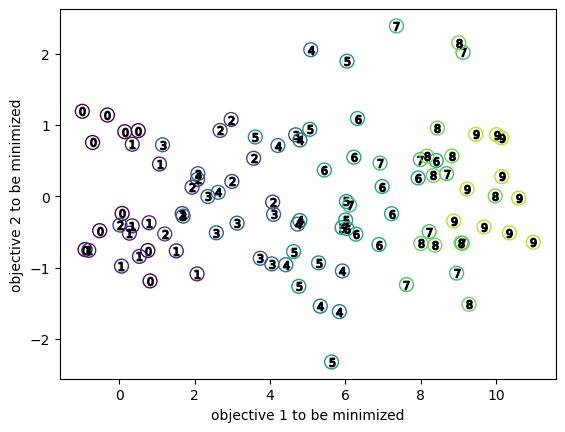

In [9]:
ax = plt.subplot()
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(samples[:10, i, 0], samples[:10, i, 1], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(samples[:10, i, 0], samples[:10, i, 1], marker=f"${i}$", color="black")

ax.set_xlabel("objective 1 to be minimized")
ax.set_ylabel("objective 2 to be minimized")

We want to learn a latent variable which describes this ranking. To do this, we suppose that there is a latent variable $\lambda_i\in \mathbb{R}^+$ associated to each model, so that for a matrix of observed scores $S_i^j$, where $i$ ranges over options, and $j$ ranges over samples per option, we have:
$$\begin{align}
E_i^j &\sim \operatorname{Exp}(\lambda_i)\\
S_{i_1}^{j_1} < \cdots < S_{i_N}^{j_N} &\Leftrightarrow E_{i_1}^{j_1} < \cdots < E_{i_N}^{j_N}
\end{align}$$
The last line states that the order of the scores is determined by the order of the respective latent samples $E_i^j$.

We fit this model via `infer_rates`, which minimizing maximum likelihood, using gibbs-sampling to integrate over the unobserved variables $E_i^j$.

Note: since $-\log(X)\sim \operatorname{Gumbel}(\log(\lambda), 1)$ whenever $X\sim\operatorname{Exp}(\lambda)$, this is equivalent to fitting latent gumbel-distributed random variables.
 

In [10]:
inferred_x = infer_rates([samples[:, i, 0] for i in range(M)], n_iter=1000)
inferred_y = infer_rates([samples[:, i, 1] for i in range(M)], n_iter=1000)

We plot the learnt gumbel-ranks:

(-1.75, 2.25)

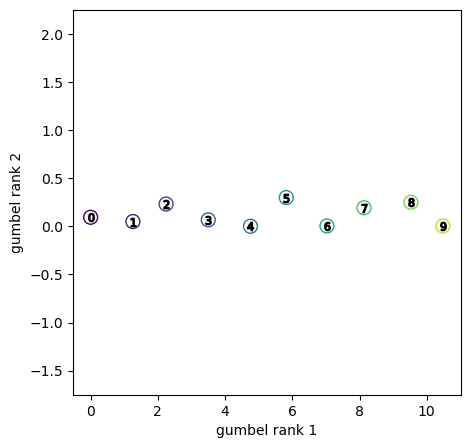

In [11]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(-np.log(inferred_x)[i], -np.log(inferred_y)[i], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(-np.log(inferred_x)[i], -np.log(inferred_y)[i], marker=f"${i}$", color="black")

ax.set_xlabel("gumbel rank 1")
ax.set_ylabel("gumbel rank 2")
ax.set_ylim((-1.75, 2.25))

The final gumbel rank is the log-sum-exp of the gumbel ranks for each scoring function, let's plot this:

Text(0.5, 1.0, 'Final Gumbel-Rank')

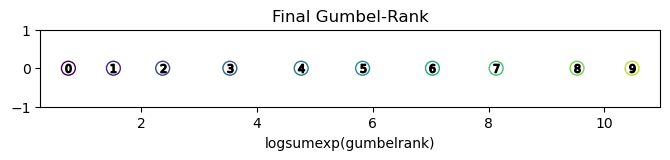

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8, 1))
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(np.log(1/inferred_x+1/inferred_y)[i],  np.zeros_like(inferred_x)[i], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(np.log(1/inferred_x+1/inferred_y)[i],  np.zeros_like(inferred_x)[i], marker=f"${i}$", color="black")

ax.set_xlabel("logsumexp(gumbelrank)")
ax.set_ylim((-1, 1))
ax.set_title("Final Gumbel-Rank")

Notice that this perfectly recovers the true order.

To provide a baseline against which to compare this, we compute the ranks of the mean scores:

In [13]:
mean_x = np.array([samples[:, i, 0].mean() for i in range(M)])
mean_y = np.array([samples[:, i, 1].mean() for i in range(M)])

Text(0, 0.5, 'rank of means 2')

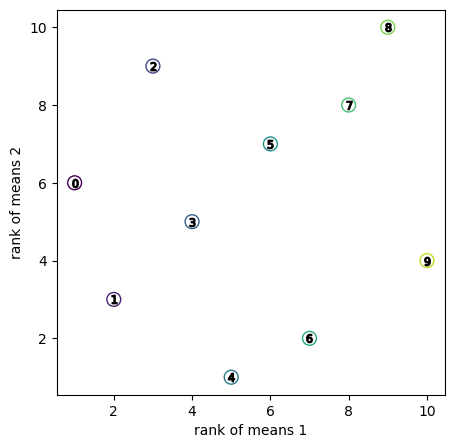

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(rankdata(mean_x)[i], rankdata(mean_y)[i], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(rankdata(mean_x)[i], rankdata(mean_y)[i], marker=f"${i}$", color="black")

ax.set_xlabel("rank of means 1")
ax.set_ylabel("rank of means 2")

Let's compute the resulting order:

In [15]:
np.argsort(np.stack([rankdata(mean_x), rankdata(mean_y)], axis=1).max(axis=1))

array([1, 3, 4, 0, 5, 6, 7, 2, 8, 9])

Note the resulting errors. The reason for this is that averaging normally distributed random noise still leads to normally distributed averages, and so the ranking along the second metric is entirely random.

# Hyperparameter optimization:

In [16]:
import torch

from rank_hpo.core import optimize_function_langevin
from rank_hpo.standard_distributions import gaussian, two_layer_mlp, gaussian_mixture

Let's start by miminizing the rosenbrock function. This is a deterministic function, and gradient based methods will outperform our black-box optimization scheme based only on ranking data. But it provides a baseline.

In [17]:
a = 1
b = 100
def rosenbrock(xy, a=a, b=b):
    x = xy[:, 0] if xy.ndim==2 else xy[0]
    y = xy[:, 1] if xy.ndim==2 else xy[1]
    return (a-x)**2+b*(y-x**2)**2

Let's plot it:

Text(0.5, 0.98, 'Plot of the rosenbrock function\nThe red x marks the global minimum.')

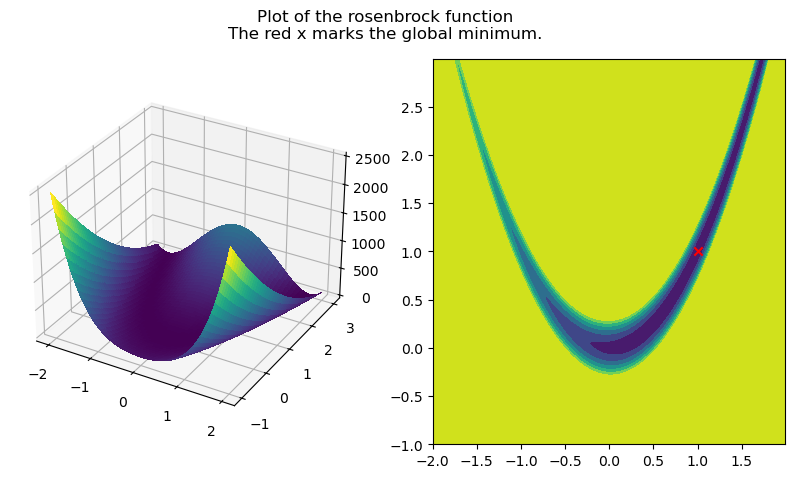

In [18]:
# Make data.
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
z = rosenbrock(pos).reshape(x.shape)

# Plot the surface.
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax1.plot_surface(x, y, z, cmap=cm.viridis, linewidth=0, antialiased=False)


# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
ax2.contourf(x, y, z.clip(max=10))
ax2.scatter(x=[1], y=[1], color="red", marker="x")
fig.suptitle("Plot of the rosenbrock function\nThe red x marks the global minimum.")

/home/dlibland/dev/rank_hpo/src/rank_hpo/core.py:149: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


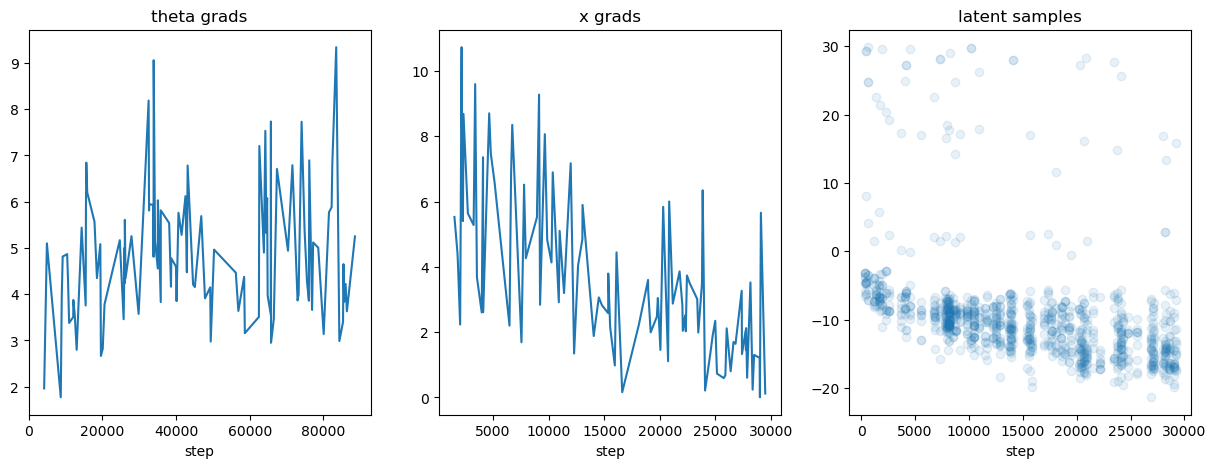

In [19]:
torch.manual_seed(13)
grid = np.mgrid[-2:2:.1, -1:3:.1].reshape(2, -1).T
log_rho = gaussian_mixture(torch.tensor(grid, device=device, requires_grad=False), std=.2)
theta = torch.zeros(size=(grid.shape[0],), requires_grad=True, dtype=torch.double, device=device)

theta, xs, ys = optimize_function_langevin(rosenbrock, 
                                           [torch.randn(2, device=device)*2 for _ in range(10)], 
                                           log_rho=log_rho, 
                                           theta=theta, 
                                           n_evals=100, 
                                           n_iter=300, 
                                           weight_decay=0, 
                                           n_langevin_steps=3,
                                           param_temperature_range=(1, .1),
                                           sample_temperature_range=(1, .1),
                                           param_step_size=1e-3,
                                           sample_step_size=3e-2
                                           )

Text(0.5, 0.98, 'Rank-Based Optimization of the Rosenbrock function')

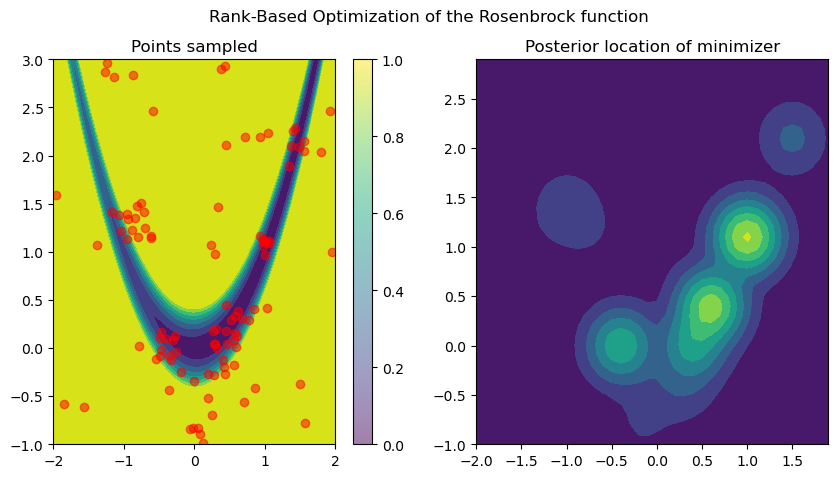

In [20]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x, y = np.mgrid[-2:2:.01, -1:3:.01]
ax1.contourf(x, y, z.clip(max=20))
scat = ax1.scatter(xs[:, 0].cpu(), xs[:,1].cpu(), alpha=0.5, color="red")
fig.colorbar(scat)
ax1.set_title("Points sampled")
ax1.set_ylim(-1, 3)
ax1.set_xlim(-2, 2)

# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.1, -1:3:.1]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
ax2.contourf(x, y, np.exp(0.5*log_rho(torch.tensor(pos).to(theta), theta).detach().cpu()).reshape(x.shape))
ax2.set_title("Posterior location of minimizer")
fig.suptitle("Rank-Based Optimization of the Rosenbrock function")


Text(0.5, 0.98, 'Rank-Based Optimization of the Rosenbrock function\n (The true minima is at (1,1)')

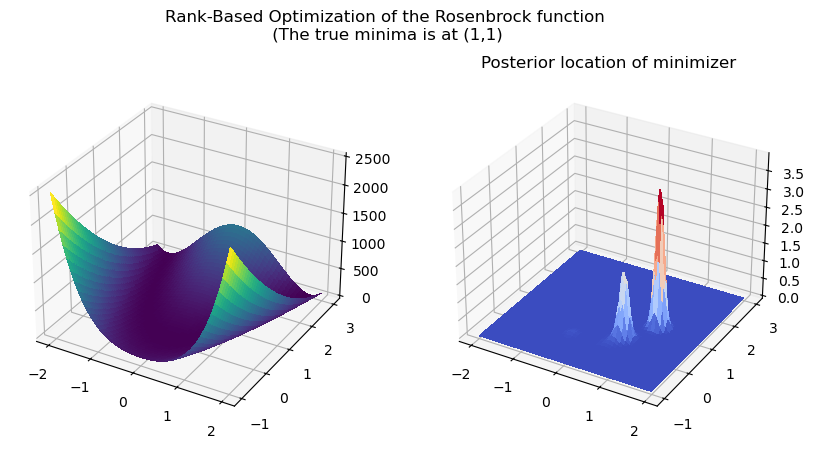

In [21]:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
z = rosenbrock(pos).reshape(x.shape)

# Plot the surface.
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax1.plot_surface(x, y, z, cmap=cm.viridis, linewidth=0, antialiased=False)

# plot a heatmap of the model:
pos = np.stack((x.flatten(), y.flatten()), axis=1)
z_pdf = np.exp(5*log_rho(torch.tensor(pos).to(theta), theta).detach().cpu()).reshape(x.shape)
ax2.plot_surface(x, y, z_pdf,  cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title("Posterior location of minimizer")
fig.suptitle("Rank-Based Optimization of the Rosenbrock function\n (The true minima is at (1,1)")


In [22]:
raise RuntimeError("Stop here")

RuntimeError: Stop here

## Random function
Now let's look at a random function.

In [ ]:
def function(x: torch.Tensor):
    return (x**2)+50*torch.exp(-(x-.5)**2/20)+5*torch.randn(size=x.shape).to(x)

In [ ]:
x_lin = torch.linspace(-10, 10, 100)
plt.plot(x_lin, function(x_lin))
plt.plot(x_lin, function(x_lin))
plt.plot(x_lin, function(x_lin))
plt.title("Random function")

In [ ]:
grid = torch.linspace(-10, 10, 30).reshape(-1,1).to(device=device)
log_rho = gaussian_mixture(grid, 1.5)
theta = torch.zeros(grid.shape[0], device=device)
# log_rho = two_layer_mlp(1)
# n_hidden = 32
# theta = torch.randn(3, n_hidden, device=device)/np.sqrt(n_hidden)


theta, xs, ys = optimize_function_langevin(
    function, 
    8*torch.randn(5, 1).to(device), 
    log_rho=log_rho,
    theta=theta,
    n_evals=30, 
    n_iter=300
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(xs.cpu())
axs[0].set_title("x-samples")
axs[1].plot(ys.cpu())
axs[1].set_title("y-samples")

In [ ]:
xs_ = torch.linspace(-10, 10, 300).reshape(-1,1).to(theta)
pdfs = torch.exp(log_rho(torch.tensor(xs_), theta)).detach().cpu().numpy()
fig, axs = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axs[1].plot(xs_.cpu(), pdfs)
axs[0].plot(xs_.cpu(), function(xs_).cpu())
axs[0].plot(xs_.cpu(), function(xs_).cpu())
axs[0].plot(xs_.cpu(), function(xs_).cpu())
axs[1].set_title("Random Function")
axs[1].set_title("Posterior location of optimal point")
axs[1].set_ylabel("relative probability")

## Simple case (quadratic function)
Here's a simple test case of a quadratic function:

In [ ]:
def function(x):
    return torch.sum(x**2)

In [ ]:
log_rho = gaussian(2)
theta = torch.randn(2)

theta, xs, ys = optimize_function_langevin(
    function, 
    [torch.tensor([10.]), torch.tensor([-12]), torch.tensor([5])], 
    log_rho=log_rho,
    theta=theta,
    n_evals=30, 
    n_iter=300
)

In [ ]:
plt.plot(xs)

In [ ]:
xs_ = np.linspace(-10, 10).reshape(-1,1)
pdfs = torch.exp(log_rho(torch.tensor(xs_), theta)).detach().numpy()
plt.plot(xs_, pdfs)

# A comparison with bayesian optimization

We can also use bayesian optimization to optimize the rosenbrock function. This should outperform our method, since it leverages the actual observed values, and not just their ranking. It provides a useful baseline.

In [ ]:
a = 1
b = 100
def rosenbrock_skopt(xy, a=a, b=b):
    x = xy[0]
    y = xy[1]
    return (a-x)**2+b*(y-x**2)**2

In [ ]:
from skopt import gp_minimize

res = gp_minimize(rosenbrock_skopt,                  # the function to minimize
                  [(-2.0, 2.0), (-1., 3.)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  random_state=1234)   # the random seed

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
z = rosenbrock(pos).reshape(x.shape)
ax1.contourf(x, y, z.clip(max=20))
x_iters = np.array(res.x_iters)
scat = ax1.scatter(x_iters[:, 0], x_iters[:, 1], alpha=0.5, color="red")
fig.colorbar(scat)
ax1.set_title("Points sampled")
ax1.set_ylim(-1, 3)
ax1.set_xlim(-2, 2)

# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.1, -1:3:.1]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
z = res.models[-1].predict(pos).reshape(x.shape)
ax2.contourf(x, y, z)
ax2.set_title("Posterior estimate of function")
fig.suptitle("Bayesian Optimization of the Rosenbrock function")